In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
# import standard scaler, linear regression, mse, kfold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
from sortedcontainers import SortedDict
# import Ridge
from sklearn.linear_model import Ridge
import numpy as np 

In [50]:
df_train = pd.read_feather('df_train.ftr')
df_test = pd.read_feather('df_test.ftr')

In [28]:
print(f'Shape of df_train: {df_train.shape}')
print(f'Million rows: {df_train.shape[0]/1e6:.1f}')

Shape of df_train: (18806580, 69)
Million rows: 18.8


In [5]:
df_test.columns[:10]

Index(['time', 'weakly_disq', 'ask~coinbase', 'bid~coinbase', 'target',
       'midprice~coinbase_logret_0s_1s', 'midprice~coinbase_logret_1s_2s',
       'midprice~coinbase_logret_2s_5s', 'midprice~binance_logret_0s_1s',
       'midprice~binance_logret_1s_2s'],
      dtype='object')

In [8]:
df_test.columns[-14:]

Index(['trade_aggr_positive~coinbase_absret_0s_1s',
       'trade_aggr_positive~coinbase_absret_1s_2s',
       'trade_aggr_positive~coinbase_absret_2s_5s',
       'trade_aggr_positive~coinbase_absret_5s_26s',
       'trade_aggr_positive~coinbase_absret_26s_136s',
       'trade_aggr_positive~coinbase_absret_136s_699s',
       'trade_aggr_positive~coinbase_absret_699s_3599s',
       'bidside_orderflow_factor~coinbase_absret_0s_1s',
       'bidside_orderflow_factor~coinbase_absret_1s_2s',
       'bidside_orderflow_factor~coinbase_absret_2s_5s',
       'bidside_orderflow_factor~coinbase_absret_5s_26s',
       'bidside_orderflow_factor~coinbase_absret_26s_136s',
       'bidside_orderflow_factor~coinbase_absret_136s_699s',
       'bidside_orderflow_factor~coinbase_absret_699s_3599s'],
      dtype='object')

In [11]:
# the time variable is unix time
df_test['time'].min()

1671580801.0

In [51]:
# adding a date column
for df in [df_train, df_test]:
    df['date'] = pd.to_datetime(df['time']*1e9)

In [15]:
# size of datasets in terms of days
df_train['date'].max() - df_train['date'].min()

Timedelta('339 days 17:07:40')

In [13]:
df_test['date'].max() - df_test['date'].min()

Timedelta('42 days 22:59:57')

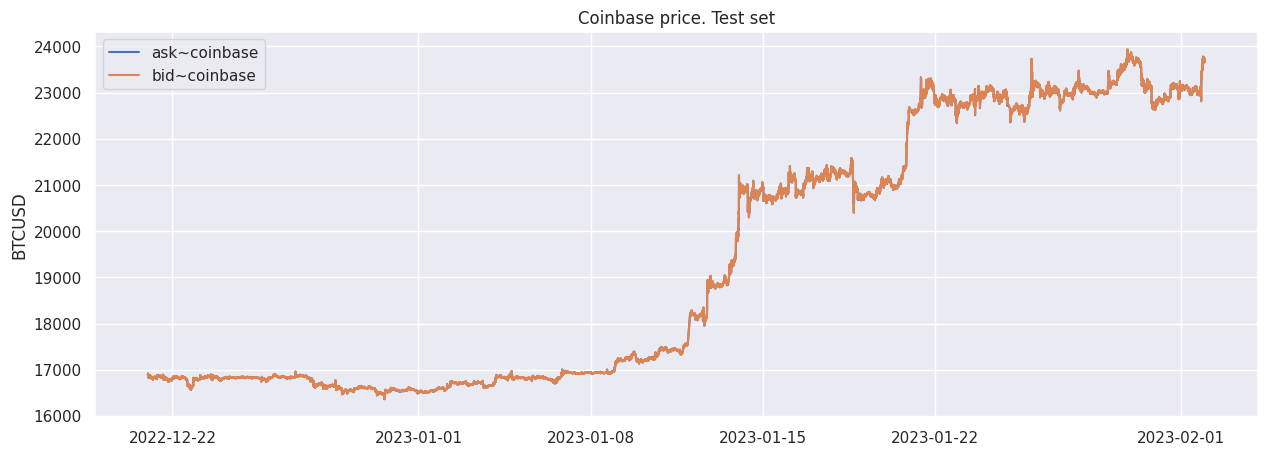

In [61]:
import seaborn as sns
sns.set()

# plot ask~coinbase, bid~coinbase against date, every 100th value. same plot
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(df_test['date'][::100], df_test['ask~coinbase'][::100], label='ask~coinbase')
ax.plot(df_test['date'][::100], df_test['bid~coinbase'][::100], label='bid~coinbase')
ax.legend()
ax.set_ylabel('BTCUSD')
ax.set_title('Coinbase price. Test set')
plt.show()




In [53]:
# Here I implement my alpha tuning method, it uses interval bisection to find the minimum of the convex(ish) error
df = df_train.copy()

# select columns with absolute returns or log returns
ret_cols = [col for col in df.columns if 'ret' in col]
df_X = df[ret_cols]
X = df_X.values
y = df['target'].values

# returns the out-of-sample MSE for a given alpha
def error_of_alpha(alpha):
    print('Testing alpha', alpha)
    kf = KFold(n_splits=3)

    # create lists to store the training and testing errors for each fold
    train_errors = []
    test_errors = []

    # iterate over the folds 
    for train_index, test_index in kf.split(X):
        # split the data into training and testing sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # fit the scaler object to the training data and transform both the training and testing data
        scaler = StandardScaler()
        model = Ridge(alpha=alpha)
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # fit the Ridge regression model to the scaled training data and make predictions on both the training and testing data
        model.fit(X_train_scaled, y_train)
        preds_train = model.predict(X_train_scaled)
        preds_test = model.predict(X_test_scaled)

        # calculate the mean squared error for this fold and append it to the appropriate list
        train_error = mean_squared_error(y_train, preds_train)
        train_errors.append(train_error)
        test_error = mean_squared_error(y_test, preds_test)
        test_errors.append(test_error)

    # calculate the mean training and testing errors over all folds
    train_error_mean, test_error_mean = np.array(train_errors).mean(), np.array(test_errors).mean()
    print(f'alpha: {alpha} error: {test_error_mean}')
    return test_error_mean

# set the scale and number of rounds for the alpha tuning process
scale = 10
rounds = 10

# check if the alpha_to_error dictionary exists in the local namespace, and if not or if True is passed as the second condition, create a new dictionary and add an initial alpha value and its corresponding testing error
if 'alpha_to_error' not in locals() or True: # True to reset
    alpha_to_error = SortedDict()
    new_alpha = 1
    alpha_to_error[new_alpha] = error_of_alpha(new_alpha)

# loop over the specified number of rounds
for round_number in range(rounds):
    print('doing round', round_number, 'of', rounds)

    # create lists of the alpha values and testing errors in the alpha_to_error dictionary
    errors = [v for v in alpha_to_error.values()]
    alphas = [k for k in alpha_to_error.keys()]

    # find the largest and smallest alpha values in the alpha_to_error dictionary
    largest_alpha = max(alphas)
    smallest_alpha = min(alphas)

    # check if all testing errors are the same, and if so, add two new alpha values 
    # scaling by 10x 

    if max(errors) == min(errors):
        print('all errors same')
        alpha_to_error[largest_alpha*scale] = error_of_alpha(largest_alpha*scale)
        alpha_to_error[smallest_alpha/scale] = error_of_alpha(smallest_alpha/scale)

    # check if the testing error for the largest alpha value is the lowest, and if so, add a new alpha value that is 10 times the largest alpha value to the alpha_to_error dictionary
    elif alpha_to_error[max(alphas)] == lowest_error:
        print('moving alpha up')
        alpha_to_error[largest_alpha*scale] = error_of_alpha(largest_alpha*scale)

    # check if the testing error for the smallest alpha value is the lowest, and if so, add a new alpha value that is the smallest alpha value divided by 10 to the alpha_to_error dictionary
    elif alpha_to_error[min(alphas)] == lowest_error:
        print('moving alpha down')
        alpha_to_error[smallest_alpha/scale] = error_of_alpha(smallest_alpha/scale)

    # if neither the largest nor smallest alpha value has the lowest testing error, find the three alpha values with the lowest testing errors and add two new alpha values to the alpha_to_error dictionary that are the averages of the middle alpha value and its two adjacent alpha values
    else:
        print('have both upper and lower bounds')

        # find the alpha value with the lowest testing error
        m = None
        for alpha, error in alpha_to_error.items():
            if error == lowest_error:
                m = alpha
                break

        # find the indices of the three alpha values around the alpha value with the lowest testing error
        alphas = sorted(alphas)
        m_index = alphas.index(m)
        a_index = m_index -1
        b_index = m_index +1

        # find the alpha values corresponding to the indices found above
        a = alphas[a_index]
        b = alphas[b_index]

        # add two new alpha values that are the averages of the middle alpha value and its two adjacent alpha values
        new_alpha = (a+m)/2
        alpha_to_error[new_alpha] = error_of_alpha(new_alpha)

        new_alpha = (b+m)/2
        alpha_to_error[new_alpha] = error_of_alpha(new_alpha)



testing alpha 1
alpha: 1 error: 1.644938500953158e-07
doing round 0 of 10
all errors same
testing alpha 10
alpha: 10 error: 1.6449055068829103e-07
testing alpha 0.1
alpha: 0.1 error: 1.6449433965470358e-07
doing round 1 of 10
moving alpha up
testing alpha 100
alpha: 100 error: 1.644794356990976e-07
doing round 2 of 10
moving alpha up
testing alpha 1000
alpha: 1000 error: 1.6454479541708682e-07
doing round 3 of 10
have both upper and lower bounds
testing alpha 55.0
alpha: 55.0 error: 1.644841784831333e-07
testing alpha 550.0
alpha: 550.0 error: 1.6447421796763362e-07
doing round 4 of 10
have both upper and lower bounds
testing alpha 325.0
alpha: 325.0 error: 1.6446684926750753e-07
testing alpha 775.0
alpha: 775.0 error: 1.645004718235413e-07
doing round 5 of 10
have both upper and lower bounds
testing alpha 212.5
alpha: 212.5 error: 1.6447058481010474e-07
testing alpha 437.5
alpha: 437.5 error: 1.6446811628062928e-07
doing round 6 of 10
have both upper and lower bounds
testing alpha 268

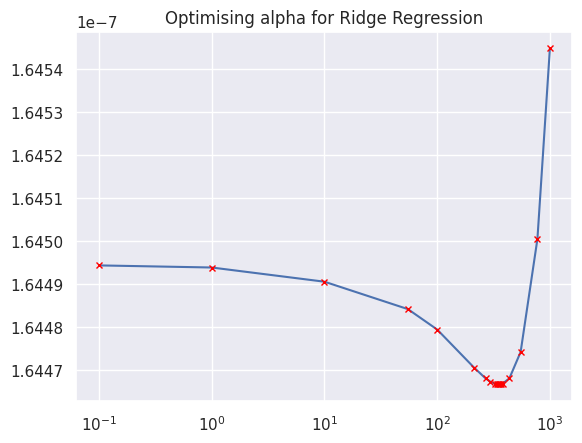

In [65]:
plt.clf()
plt.plot(list(alpha_to_error.keys()), list(alpha_to_error.values()), marker = 'x', markeredgecolor='red', markersize=5)
plt.xscale('log')
plt.title('Optimising alpha for Ridge Regression')
plt.show()

In [69]:
# Here I examine the size of the coefficients for the best regularised regression model

# find the alpha value in the alpha_to_error dictionary with the lowest testing error
best_alpha = min(alpha_to_error, key=alpha_to_error.get)

# create a new Ridge regression object with the best alpha value
model = Ridge(alpha=best_alpha)

# create a new StandardScaler object and fit it to the entire train dataset X
scaler = StandardScaler()
scaler.fit(X)

# fit the Ridge regression model to the scaled dataset X and target variable y
model.fit(scaler.transform(X), y)

# create a dataframe containing the coefficients for each feature in the df_X dataframe and their corresponding column names
cols = df_X.columns
dfc = pd.DataFrame(list(zip(model.coef_, cols)))

# add a third column to the dataframe containing the absolute values of the coefficients
dfc[2] = np.abs(dfc[0])

# sort the dataframe by the absolute values of the coefficients in descending order
dfc = dfc.sort_values(by=2, ascending=False)
dfc.columns = ['coefficient', 'feature', 'abs_coefficient']

dfc.head(30)

,coefficient,feature,abs_coefficient
35,0.000648,trade_aggr_positive~binance_absret_0s_1s,0.000648
12,-0.000487,trade_aggr_negative~binance_absret_0s_1s,0.000487
42,0.000389,bidside_orderflow_factor~binance_absret_0s_1s,0.000389
6,-0.000317,askside_orderflow_factor~binance_absret_0s_1s,0.000317
49,0.000307,trade_aggr_positive~coinbase_absret_0s_1s,0.000307
9,-0.000275,trade_aggr_negative~coinbase_absret_0s_1s,0.000275
50,0.000190,trade_aggr_positive~coinbase_absret_1s_2s,0.000190
10,-0.000183,trade_aggr_negative~coinbase_absret_1s_2s,0.000183
36,0.000182,trade_aggr_positive~binance_absret_1s_2s,0.000182
13,-0.000154,trade_aggr_negative~binance_absret_1s_2s,0.000154


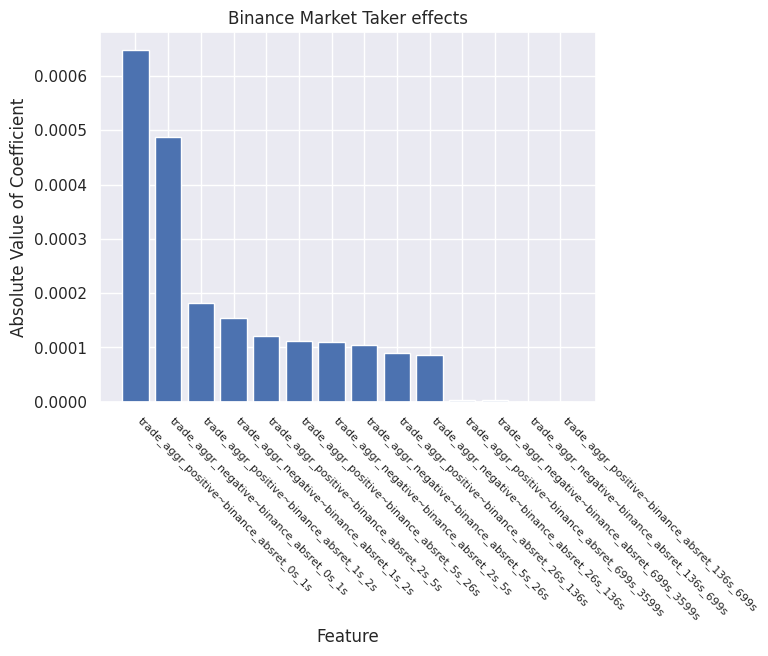

In [78]:
# examing coefficients related to market takers, executed trades
import matplotlib.pyplot as plt

# Extract the top 30 rows from the DataFrame that contain 'aggr_' and 'binance'
top30 = dfc[dfc['feature'].str.contains('aggr_')]
top30 = top30[top30['feature'].str.contains('binance')]
top30 = top30.head(30)

# Plot the absolute values
plt.bar(top30['feature'], top30['abs_coefficient'])
plt.xticks(rotation=-45, ha='left', fontsize=8)  # set diagonal rotation, left alignment, and fontsize for x-axis labels
plt.xlabel('Feature')
plt.ylabel('Absolute Value of Coefficient')
plt.title('Binance Market Taker effects')
plt.show()


In [80]:
# There is a real cut off in historic time windows, making older features less relevant
# To investigate this I will use stepwise subset selection to find the best subset of features, simplifying the model

In [82]:
all_cols = list(df_X.columns)
used_cols = []
best_mse = float('inf')

# continue adding features until MSE stops improving
while True:
    best_mse_this_round = float('inf')
    best_set_this_round = []
    
    # loop over all remaining columns
    for col in all_cols:
        if col in used_cols:
            continue
        this_round_cols = used_cols.copy()
        this_round_cols.append(col)
        print('trying', this_round_cols)
        error_data = []
        test_errors = []
        X = df_X[this_round_cols].values
        
        # perform k-fold cross validation
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            scaler = StandardScaler()
            model = LinearRegression()
            scaler.fit(X_train)
            model.fit(scaler.transform(X_train), y_train)
            preds_test = model.predict(scaler.transform(X_test))
            error = mean_squared_error(y_test, preds_test)
            test_errors.append(error)
        test_error = np.array(test_errors).mean()
        
        # update best MSE and feature set if improvement is found
        if test_error <= best_mse_this_round:
            print('found better error for this round: ', test_error, 'cols:', this_round_cols)
            best_set_this_round = this_round_cols.copy()
            best_mse_this_round = test_error
    
    # break if no improvement in MSE is found
    if best_mse_this_round >=  best_mse:
        break
    
    # print and update best MSE and feature set if improvement is found
    else:
        print('improved ---------------')
        print(best_set_this_round)
        print('------------------------')
        best_mse = best_mse_this_round
        used_cols = best_set_this_round.copy()


trying ['midprice~coinbase_logret_0s_1s']
found better error for this round:  9.722887696532862e-07 cols: ['midprice~coinbase_logret_0s_1s']
trying ['midprice~coinbase_logret_1s_2s']
trying ['midprice~coinbase_logret_2s_5s']
trying ['midprice~binance_logret_0s_1s']
found better error for this round:  9.686130263572202e-07 cols: ['midprice~binance_logret_0s_1s']
trying ['midprice~binance_logret_1s_2s']
trying ['midprice~binance_logret_2s_5s']
trying ['askside_orderflow_factor~binance_absret_0s_1s']
trying ['askside_orderflow_factor~binance_absret_1s_2s']
trying ['askside_orderflow_factor~binance_absret_2s_5s']
trying ['trade_aggr_negative~coinbase_absret_0s_1s']
trying ['trade_aggr_negative~coinbase_absret_1s_2s']
trying ['trade_aggr_negative~coinbase_absret_2s_5s']
...trying ['trade_aggr_positive~binance_absret_0s_1s', 'trade_aggr_negative~binance_absret_0s_1s', 'bidside_orderflow_factor~binance_absret_0s_1s', 'askside_orderflow_factor~binance_absret_0s_1s', 'trade_aggr_positive~coinba

In [84]:
# features in order of importance...
best_set_this_round[:10]

['trade_aggr_positive~binance_absret_0s_1s',
 'trade_aggr_negative~binance_absret_0s_1s',
 'bidside_orderflow_factor~binance_absret_0s_1s',
 'askside_orderflow_factor~binance_absret_0s_1s',
 'trade_aggr_positive~coinbase_absret_0s_1s',
 'trade_aggr_negative~coinbase_absret_0s_1s',
 'bidside_orderflow_factor~coinbase_absret_0s_1s',
 'trade_aggr_positive~binance_absret_1s_2s',
 'trade_aggr_negative~binance_absret_1s_2s',
 'trade_aggr_positive~coinbase_absret_1s_2s']

In [85]:
# original dimensionality 
len(all_cols)

63

In [88]:
# new dimensionality
len(best_set_this_round)

30

In [91]:
best_cols = best_set_this_round

In [93]:
df_X = df_X[best_cols]
X = df_X.values

In [94]:
# refit new alpha 
scale = 10
rounds = 10
if 'alpha_to_error' not in locals() or True: # True to reset
    alpha_to_error = SortedDict()
    new_alpha = 1
    alpha_to_error[new_alpha] = error_of_alpha(new_alpha)
for round_number in range(rounds):
    print('doing round', round_number, 'of', rounds)
    errors = [v for v in alpha_to_error.values()]
    alphas = [k for k in alpha_to_error.keys()]
    lowest_error = min(errors)
    largest_alpha = max(alphas)
    smallest_alpha = min(alphas)
    if max(errors) == min(errors):
        print('all errors same')
        alpha_to_error[largest_alpha*scale] = error_of_alpha(largest_alpha*scale)
        alpha_to_error[smallest_alpha/scale] = error_of_alpha(smallest_alpha/scale)
    elif alpha_to_error[max(alphas)] == lowest_error:
        print('moving alpha up')
        alpha_to_error[largest_alpha*scale] = error_of_alpha(largest_alpha*scale)
    elif alpha_to_error[min(alphas)] == lowest_error:
        print('moving alpha down')
        alpha_to_error[smallest_alpha/scale] = error_of_alpha(smallest_alpha/scale)
    else:
        # a,m,b will be the alphas around the lowest error
        print('have both upper and lower bounds')
        m = None
        for alpha, error in alpha_to_error.items():
            if error == lowest_error:
                m = alpha
                break
        alphas = sorted(alphas)
        m_index = alphas.index(m)
        a_index = m_index -1
        b_index = m_index +1
        a = alphas[a_index]
        b = alphas[b_index]
        new_alpha = (a+m)/2
        # print('doing new alpha', new_alpha)
        alpha_to_error[new_alpha] = error_of_alpha(new_alpha)    
        new_alpha = (b+m)/2
        alpha_to_error[new_alpha] = error_of_alpha(new_alpha)

testing alpha 1
alpha: 1 error: 1.6465632891951826e-07
doing round 0 of 10
all errors same
testing alpha 10
alpha: 10 error: 1.6465322742914677e-07
testing alpha 0.1
alpha: 0.1 error: 1.6465664846439607e-07
doing round 1 of 10
moving alpha up
testing alpha 100
alpha: 100 error: 1.6462931162802175e-07
doing round 2 of 10
moving alpha up
testing alpha 1000
alpha: 1000 error: 1.646455533215758e-07
doing round 3 of 10
have both upper and lower bounds
testing alpha 55.0
alpha: 55.0 error: 1.6463989051209118e-07
testing alpha 550.0
alpha: 550.0 error: 1.6459554608000707e-07
doing round 4 of 10
have both upper and lower bounds
testing alpha 325.0
alpha: 325.0 error: 1.6459988520246868e-07
testing alpha 775.0
alpha: 775.0 error: 1.6461130553797052e-07
doing round 5 of 10
have both upper and lower bounds
testing alpha 437.5
alpha: 437.5 error: 1.645950512072696e-07
testing alpha 662.5
alpha: 662.5 error: 1.6460103524720455e-07
doing round 6 of 10
have both upper and lower bounds
testing alpha 3

In [97]:
# retrain model on all train data with best alpha
best_alpha = min(alpha_to_error, key=alpha_to_error.get)
scaler = StandardScaler()
model = Ridge(alpha=best_alpha)
scaler.fit(X)
model.fit(scaler.transform(X), y)

Ridge(alpha=479.6875)

In [99]:
# test on test data
X_test = df_test[best_cols].values

# make predictions
preds_test = model.predict(scaler.transform(X_test))

In [103]:
[col for col in df_test.columns if 'ret' not in col]
#['time', 'weakly_disq', 'ask~coinbase', 'bid~coinbase', 'target', 'date']

['time', 'weakly_disq', 'ask~coinbase', 'bid~coinbase', 'target', 'date']

In [104]:
df_test['midprice~coinbase'] = (df_test['ask~coinbase'] + df_test['bid~coinbase'])/2

In [111]:
df_test['preds'] = preds_test
# predictions are in log future returns, so first convert to proportions, then predicted midprice
df_test['pred_midprice'] = df_test['midprice~coinbase'] * np.exp(df_test['preds'])

<AxesSubplot: xlabel='time'>

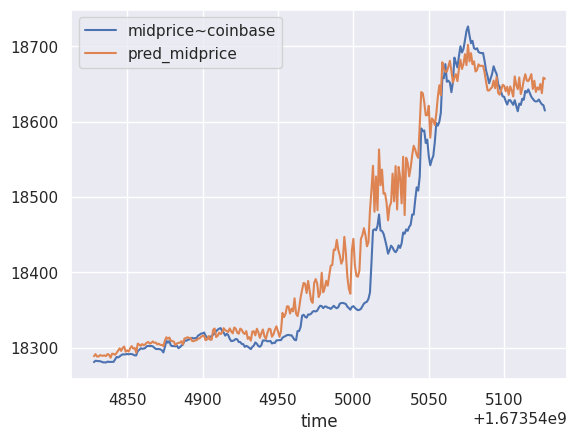

In [114]:
# find the idx of largest prediction 
idx = df_test['preds'].idxmax()
# plot 100 around that idx
df_test[idx-200:idx+100].plot(x='time', y=['midprice~coinbase', 'pred_midprice'])

<AxesSubplot: xlabel='time'>

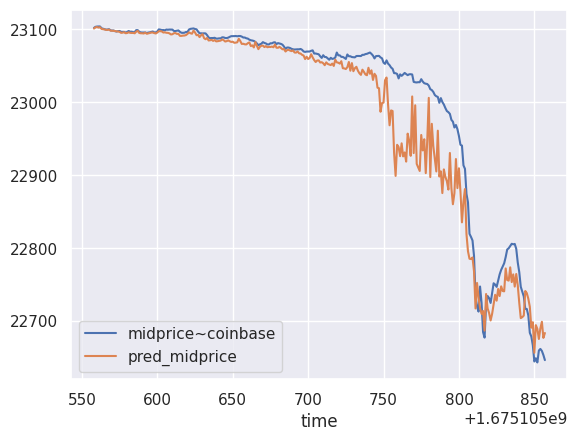

In [115]:
# find the idx of lowest prediction 
idx = df_test['preds'].idxmin()
# plot 100 around that idx
df_test[idx-200:idx+100].plot(x='time', y=['midprice~coinbase', 'pred_midprice'])